#improt libraries

In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, SimpleRNN
from keras.optimizers import RMSprop,Adam
from keras.regularizers import l2
from keras.callbacks import History
from keras import callbacks
from keras.utils import to_categorical

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/data/NASA_Turbofan_Jet")

In [4]:
# def prepare_data(drop_cols = True):
#     dependent_var = ['RUL']
#     index_columns_names =  ["UnitNumber","Cycle"]
#     operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
#     sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
#     input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

#     cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure14',
#      'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

#     df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

#     rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
#     rul.columns = ['UnitNumber', 'max']
#     df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
#     df_train['RUL'] = df_train['max'] - df_train['Cycle']
#     df_train.drop('max', axis=1, inplace=True)
#     df_train['failure_lbl_1'] = [1 if i < 75 else 0 for i in df_train.RUL]
#     # df_train['failure_lbl_2'] = df_train['failure_lbl_1']
#     # df_train.failure_lbl_2[df_train.RUL < 50] = 2

#     df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

#     if(drop_cols == True):
#         df_train = df_train.drop(cols_to_drop, axis = 1)
#         df_test = df_test.drop(cols_to_drop, axis = 1)

#     y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
#     y_true["UnitNumber"] = y_true.index
#     y_true['failure_lbl_1'] = [1 if i < 75 else 0 for i in y_true.RUL]
#     # y_true['failure_lbl_2'] = y_true['failure_lbl_1']
#     # y_true.failure_lbl_2[y_true.RUL < 50] = 2

#     return df_train, df_test, y_true

In [5]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index

    return df_train, df_test, y_true

In [6]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 19), (13096, 18), (100, 2))

In [7]:
df_train['failure'] = [1 if i < 75 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 75 else 0 for i in y_true.RUL]

In [8]:
y_true

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,1
3,82,3,0
4,91,4,0
...,...,...,...
95,137,95,0
96,82,96,0
97,59,97,1
98,117,98,0


In [9]:
# feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])
# feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1'])

In [11]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure'])

In [12]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [13]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,1.0,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,1.0,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,1.0,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,1.0,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,1.0,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [14]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,1.0,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,1.0,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,1.0,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,1.0,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,1.0,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [15]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,1
3,82,3,0
4,91,4,0


In [16]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [17]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [18]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value

    id_df = df_mask.append(id_df,ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)


# Function for showing results

In [19]:
def results(y_test, y_pred, multi_class = False):

    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred)
        print ("Area under curve : ",model_roc_auc,"\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)

        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

    plt.show()

#Data preprocessing

In [20]:
sequence_length = 50
mask_value = 0
label = "failure"

In [21]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 16)


In [22]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [23]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 16)


<ipython-input-18-2a90c44ee4fa>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_df = df_mask.append(id_df,ignore_index=True)


In [24]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

In [25]:
nb_features = x_train.shape[2]
nb_out = 1

In [26]:
nb_features

16

In [27]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt

array([0.9555947 , 1.04873333])

In [28]:
cls_wt={0:0.9555947, 1: 1.04873333 }

In [29]:
class_0 = pd.Series(y_train).value_counts()[0]
print(class_0)
class_1 = pd.Series(y_train).value_counts()[1]
print(class_1)
total = class_0 + class_1

cls_wt = {0: class_1/total, 1: class_0/total}
print(cls_wt)

8231
7500
{0: 0.4767656220202149, 1: 0.5232343779797851}


#CNN1D

In [31]:
history = History()

model = Sequential()
model.add(Conv1D(50, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model.add(Conv1D(50, 6, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(Conv1D(100, 6, activation = 'relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 45, 50)            4850      
                                                                 
 conv1d_5 (Conv1D)           (None, 40, 50)            15050     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 100)            30100     
                                                                 
 conv1d_7 (Conv1D)           (None, 3, 100)            60100     
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                            

In [32]:
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1,
          callbacks = [history,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10
222/222 [==============================] - 7s 22ms/step - loss: 0.3213 - accuracy: 0.8536 - val_loss: 0.2548 - val_accuracy: 0.8748
Epoch 2/10
222/222 [==============================] - 11s 51ms/step - loss: 0.1760 - accuracy: 0.9318 - val_loss: 0.3001 - val_accuracy: 0.8856
Epoch 3/10
222/222 [==============================] - 8s 35ms/step - loss: 0.0899 - accuracy: 0.9669 - val_loss: 0.3535 - val_accuracy: 0.8933
Epoch 4/10
222/222 [==============================] - 7s 31ms/step - loss: 0.0483 - accuracy: 0.9827 - val_loss: 0.3623 - val_accuracy: 0.8793


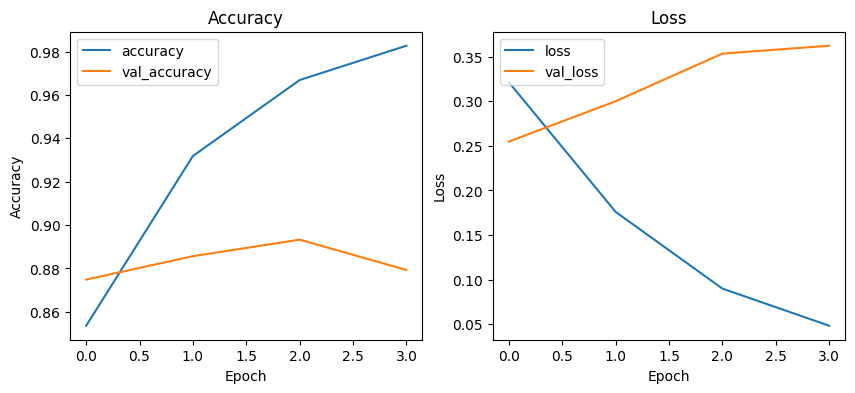

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

4/4 [==============================] - 0s 4ms/step
F1 Score:  0.888888888888889
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        57
           1       0.85      0.93      0.89        43

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Area under curve :  0.9037127702978376 



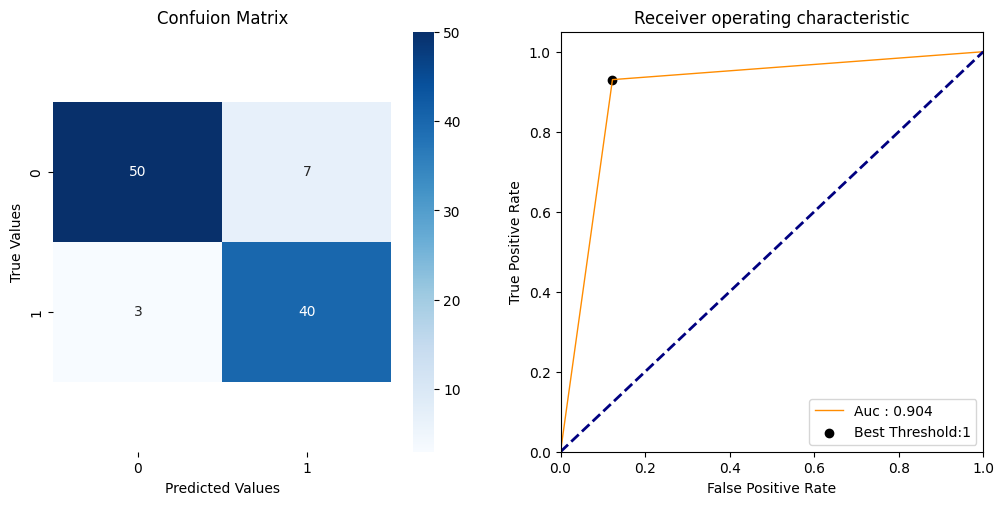

In [34]:
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
results(y_true.failure, y_pred)

In [35]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10
222/222 [==============================] - 5s 21ms/step - loss: 0.0157 - accuracy: 0.9888 - val_loss: 0.5162 - val_accuracy: 0.8825
Epoch 2/10
222/222 [==============================] - 7s 30ms/step - loss: 0.0152 - accuracy: 0.9874 - val_loss: 0.3615 - val_accuracy: 0.8983
Epoch 3/10
222/222 [==============================] - 5s 21ms/step - loss: 0.0109 - accuracy: 0.9921 - val_loss: 0.4421 - val_accuracy: 0.8799
Epoch 4/10
222/222 [==============================] - 5s 21ms/step - loss: 0.0097 - accuracy: 0.9924 - val_loss: 0.5310 - val_accuracy: 0.8799
Epoch 5/10
222/222 [==============================] - 7s 30ms/step - loss: 0.0099 - accuracy: 0.9922 - val_loss: 0.5345 - val_accuracy: 0.8901
CPU times: user 36.6 s, sys: 1.29 s, total: 37.9 s
Wall time: 28.1 s


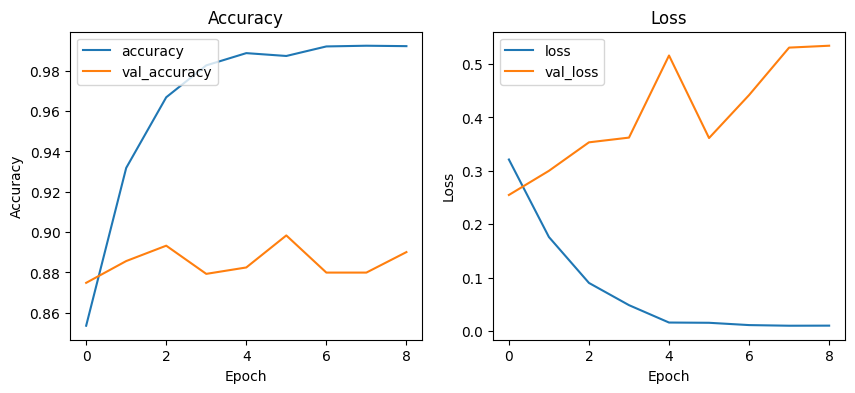

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['accuracy', 'val_accuracy'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['loss', 'val_loss'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

In [37]:
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

4/4 [==============================] - 0s 5ms/step


F1 Score:  0.8809523809523809
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        57
           1       0.90      0.86      0.88        43

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Area under curve :  0.8951448388412893 



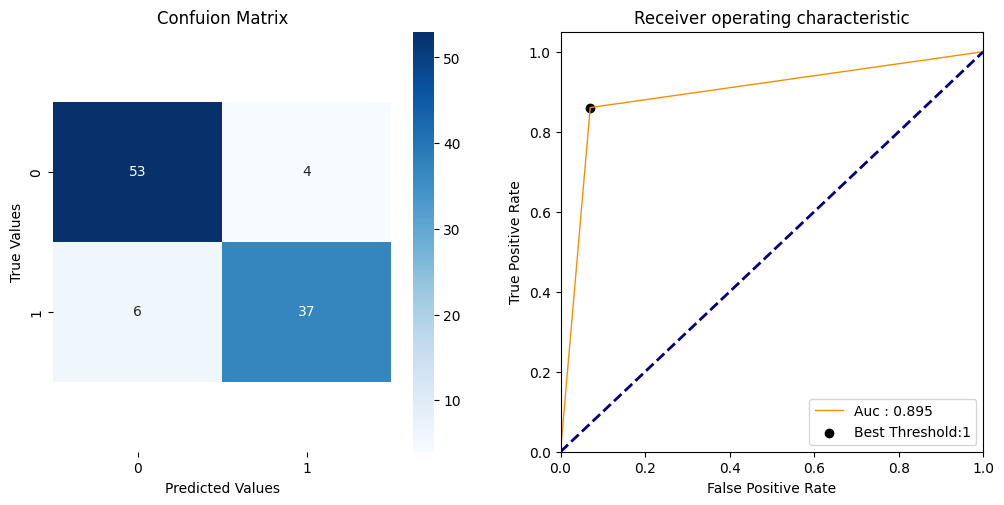

In [38]:
results(y_true.failure, y_pred)

#RNN

In [39]:
history = History()

model = Sequential()
model.add(SimpleRNN(16, input_shape=(sequence_length, nb_features),
                    activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 673 (2.63 KB)
Trainable params: 673 (2.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, class_weight = cls_wt,
          callbacks = [history,
                      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')])

Epoch 1/100
197/197 [==============================] - 3s 12ms/step - loss: 0.2018 - accuracy: 0.8131 - val_loss: 0.2909 - val_accuracy: 0.8805
Epoch 2/100
197/197 [==============================] - 2s 9ms/step - loss: 0.1282 - accuracy: 0.8922 - val_loss: 0.2492 - val_accuracy: 0.8977
Epoch 3/100
197/197 [==============================] - 2s 12ms/step - loss: 0.1144 - accuracy: 0.9028 - val_loss: 0.2228 - val_accuracy: 0.8967
Epoch 4/100
197/197 [==============================] - 3s 17ms/step - loss: 0.1046 - accuracy: 0.9104 - val_loss: 0.2012 - val_accuracy: 0.9104
Epoch 5/100
197/197 [==============================] - 2s 11ms/step - loss: 0.1065 - accuracy: 0.9100 - val_loss: 0.3735 - val_accuracy: 0.8335
Epoch 6/100
197/197 [==============================] - 2s 10ms/step - loss: 0.1011 - accuracy: 0.9115 - val_loss: 0.2035 - val_accuracy: 0.9123
Epoch 7/100
197/197 [==============================] - 2s 10ms/step - loss: 0.0979 - accuracy: 0.9147 - val_loss: 0.2650 - val_accuracy: 

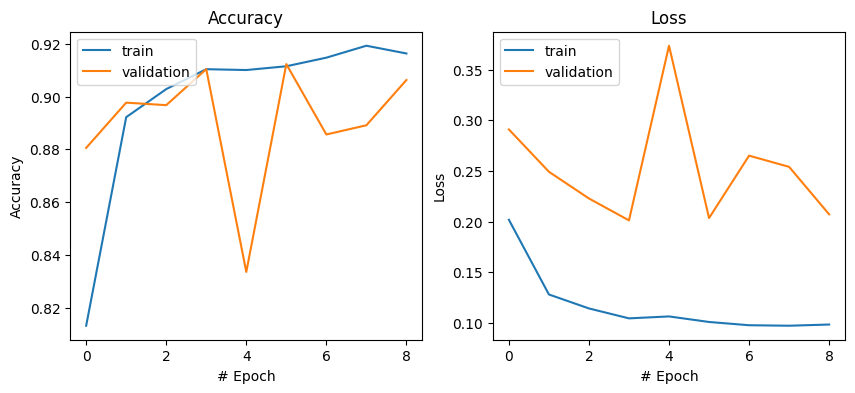

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')
plt.show()

In [42]:
y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

4/4 [==============================] - 0s 5ms/step


In [43]:
# y_pred_probs

F1 Score:  0.9047619047619047
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        57
           1       0.93      0.88      0.90        43

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

Area under curve :  0.915544675642595 



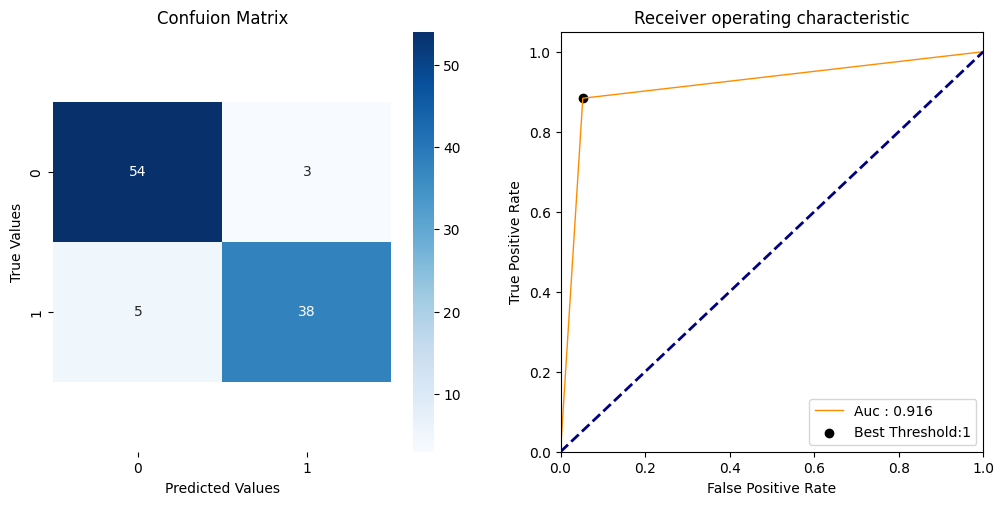

In [45]:
results(y_true.failure, y_pred, multi_class=False)